In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [26]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               label_mode="categorical",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(224, 224),
                                                               batch_size=100)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(224, 224),
                                                                batch_size=100)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            color_mode="rgb",
                                                            image_size=(224, 224),
                                                            batch_size = 100)



Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.
Found 624 files belonging to 3 classes.


In [2]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
artifact_uri = "mlflow-artifacts:/140308137141938706/cab1e769583c4ce9a4a54141e0d79f57/artifacts/finalized_model"

try:
    mlflow.artifacts.download_artifacts(
        artifact_uri=artifact_uri, dst_path="./models"
    )
except Exception as mlflow_error:
    raise mlflow_error

In [3]:
model_file = os.path.split(artifact_uri)[1]
model_file

'finalized_model'

In [4]:
model = tf.keras.models.load_model(f"./models/{model_file}")


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [47]:
img_arrays = []
# prediction_probs = np.empty((0,3), float)
predictions = np.array([])
labels =  np.array([])
# labels_encoded = np.empty((0,3), int)
for x, y in test_dataset:
  img_arrays = img_arrays + tf.unstack(x)
  prediction_prob = model.predict(x)
  # prediction_probs = np.vstack([prediction_probs, prediction_prob])
  predictions = np.concatenate([predictions, prediction_prob.argmax(axis=1)])
  # labels_encoded = np.vstack([labels_encoded, y.numpy()])
  labels = np.concatenate([labels, y.numpy().argmax(axis=1)])

1/1 [==============================] - 1s 501ms/step


In [53]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [64]:
list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))[-1].name

'Conv_1'

In [71]:
conv_layers = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))
len(conv_layers)

35

1/1 [==============================] - 0s 87ms/step


C:\Users\angus\AppData\Local\Temp\ipykernel_25412\2197667533.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


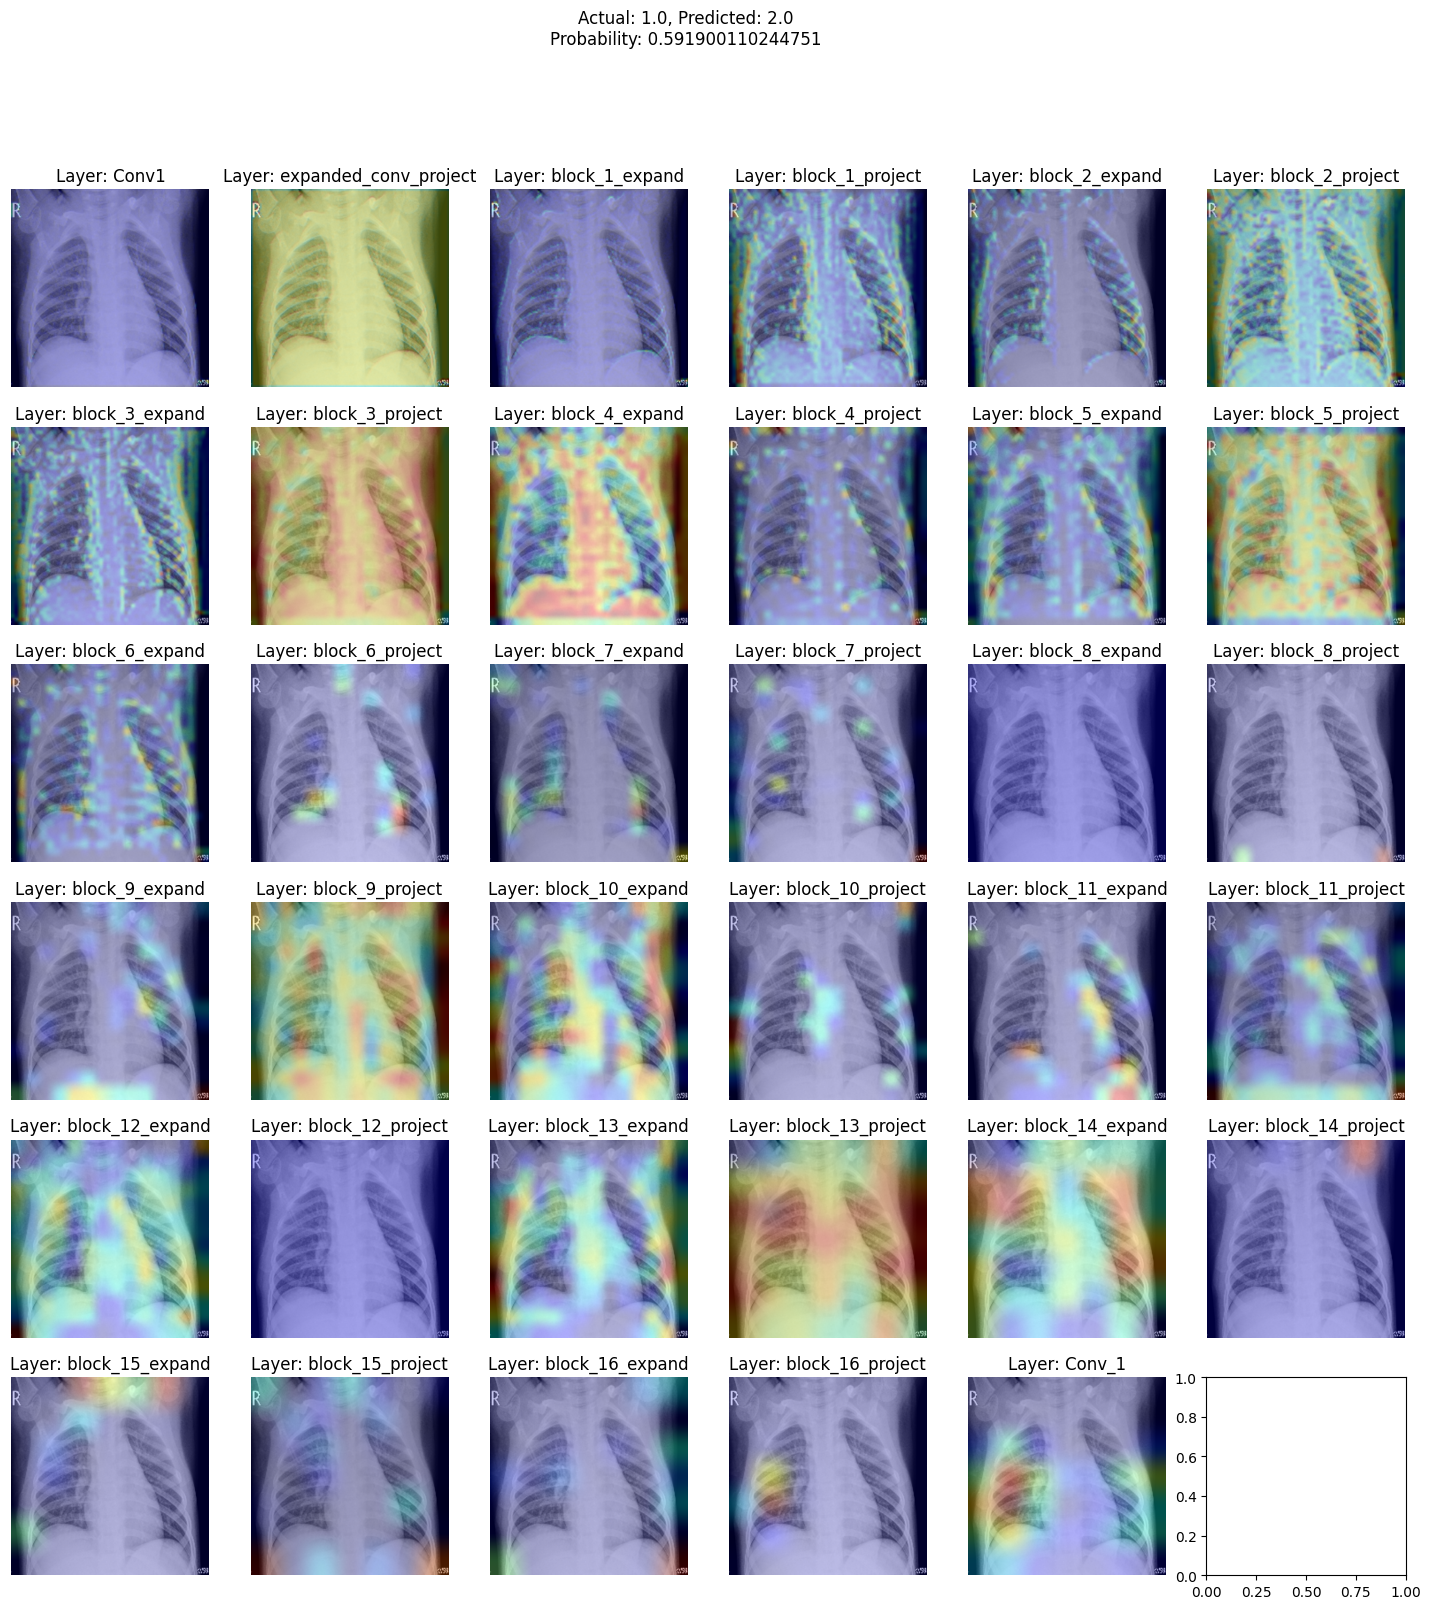

In [74]:
img_array = img_arrays[0]
prediction_probs = np.array(model.predict(np.expand_dims(img_array, axis=0))[0])
prediction_prob = max(prediction_probs)
prediction = predictions[0]
label =  labels[0]
img_tensor = np.expand_dims(img_array, axis=0)

n=6
fig, axes = plt.subplots(n,n, figsize=(18,18))
fig.suptitle(f"Actual: {label}, Predicted: {prediction}\nProbability: {prediction_prob}")


for i in range(len(conv_layers)):
    conv_layer = conv_layers[i]
    conv_layer_name = conv_layer.name
    heatmap = make_gradcam_heatmap(img_tensor, model, conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    # Create an image with RGB colorized heatmap
    img_array_resized = tf.keras.preprocessing.image.array_to_img(img_array)
    img_array_resized = img_array_resized.resize((500, 500))
    img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)


    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array_resized.shape[0], img_array_resized.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array_resized
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    axes[i//n, i%n].imshow(superimposed_img)
    axes[i//n, i%n].set_title(f"Layer: {conv_layer_name}")
    axes[i//n, i%n].axis('off')

In [31]:
len(model.trainable_variables)

14

In [8]:
model.trainable=True

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [10]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))


Number of layers in the base model:  166


In [11]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [12]:
len(model.trainable_variables)

22

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [14]:
# https://keras.io/api/layers/normalization_layers/batch_normalization/
bn_layers = list(filter(lambda x: isinstance(x, tf.keras.layers.BatchNormalization), model.layers))
for layer in bn_layers:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [38]:
# As you are training a much larger model and want to readapt the pretrained weights,
# it is important to use a lower learning rate at this stage.
# Otherwise, your model could overfit very quickly.
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy','Precision','Recall','AUC'])

In [39]:
n_epochs=15
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/15
42/42 [==============================] - 167s 4s/step - loss: 0.5674 - accuracy: 0.7498 - precision: 0.7682 - recall: 0.7244 - auc: 0.9071 - val_loss: 0.5183 - val_accuracy: 0.7795 - val_precision: 0.8016 - val_recall: 0.7555 - val_auc: 0.9226
Epoch 2/15
42/42 [==============================] - 156s 4s/step - loss: 0.5261 - accuracy: 0.7783 - precision: 0.7929 - recall: 0.7599 - auc: 0.9195 - val_loss: 0.5091 - val_accuracy: 0.7852 - val_precision: 0.8080 - val_recall: 0.7584 - val_auc: 0.9251
Epoch 3/15
42/42 [==============================] - 164s 4s/step - loss: 0.5259 - accuracy: 0.7767 - precision: 0.7911 - recall: 0.7532 - auc: 0.9195 - val_loss: 0.5171 - val_accuracy: 0.7824 - val_precision: 0.7945 - val_recall: 0.7526 - val_auc: 0.9234
Epoch 4/15
42/42 [==============================] - 154s 4s/step - loss: 0.5140 - accuracy: 0.7759 - precision: 0.7915 - recall: 0.7580 - auc: 0.9232 - val_loss: 0.5370 - val_accuracy: 0.7747 - val_precision: 0.7947 - val_recall: 0.749

Text(0.5, 1.0, 'Training and validation accuracy')

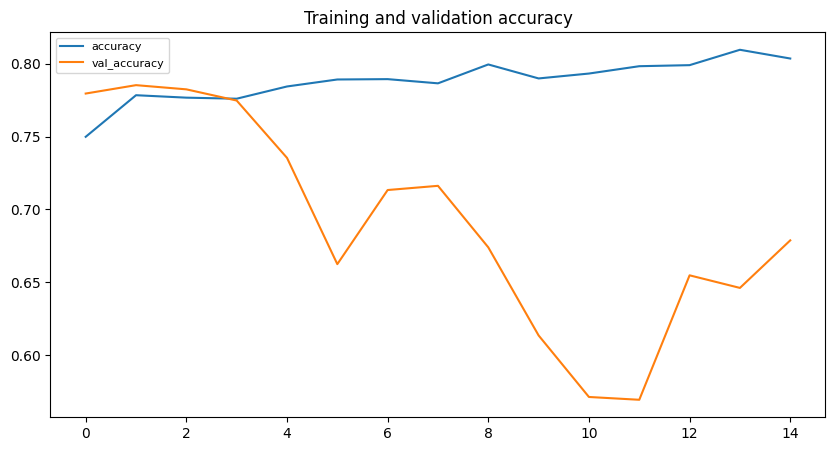

In [40]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation precision')

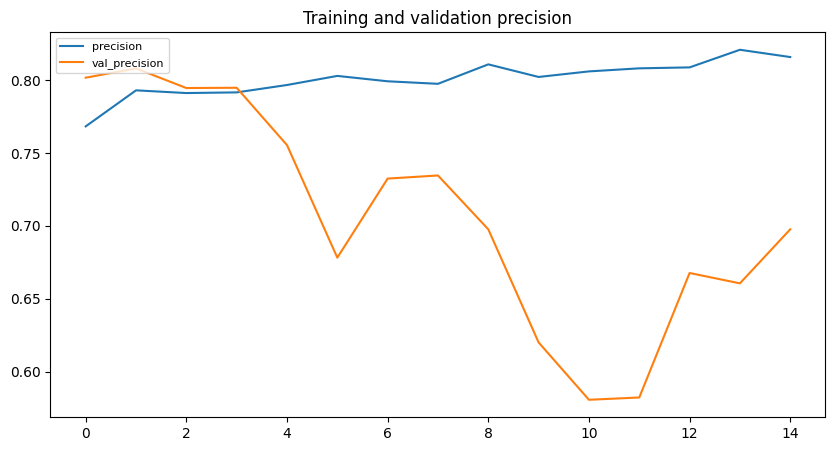

In [41]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

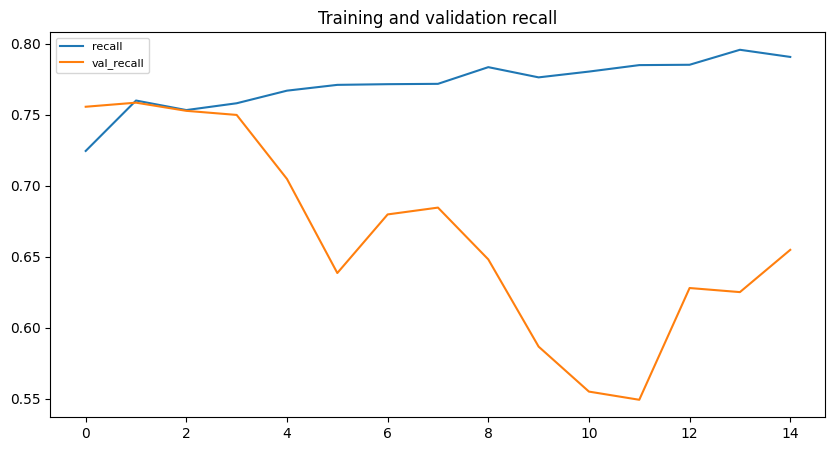

In [42]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [43]:
model.evaluate(test_dataset)

7/7 [==============================] - 18s 2s/step - loss: 1.2851 - accuracy: 0.6042 - precision: 0.6360 - recall: 0.5769 - auc: 0.7590


[1.285107970237732,
 0.6041666865348816,
 0.6360424160957336,
 0.5769230723381042,
 0.7589899301528931]